### Step 5: Visualizing results of clustering.

__Step goal__: 

__Step overview__:

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import requests, zipfile, io
from datetime import datetime
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from tqdm import tqdm
from shapely.geometry import Point, Polygon, box, shape
from src.visualization.visualize import kdeplot
from src.data.census.canada.prepare_ca_data import create_hexgrid
from src.data.accessibility.urban_access import create_hex_access
from src.data.accessibility.urban_access import access_score
%matplotlib inline

In [2]:
# Load city geometry, accessibility points, and variable names
city = 'Chicago' #montréal
country = 'united_states'
city_initials = 'CHI'
extended_variables = True

if extended_variables == False:

    # Load the names of used variables 
    if country == 'canada':
        variable_names = pd.read_csv(f'../../variables/{city}_short_variable_names.csv')['variable_name'].tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.json')
        
    if country == 'united_states':
        variable_names = pd.read_csv(f'../../variables/{city}_short.csv').columns.tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.geojson')

else:
    if country == 'canada':
        variable_names = pd.read_csv(f'../../variables/{city}_variable_names.csv')['variable_name'].tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.json')
        
    if country == 'united_states':
        variable_names = pd.read_csv(f'../../variables/{city}.csv').columns.tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.geojson')
        
# clip census of houston to city boundaries (this is because census api gives metro area rather than city)
if city == 'houston':
    
    url = 'https://opendata.arcgis.com/datasets/f67fe01244ce4d60add8e99e8e2f3a8c_0.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))

    directory = "../../data/raw/census/united_states/"
    
    if not os.path.exists(directory):
        print(f'Succefully created new directory {directory}')
        os.makedirs(directory)

    z.extractall(path=directory)
    
    limits = gpd.read_file(directory + 'City_of_Houston_City_Limits__Full_and_Limited_Purpose_Areas_.shp')
    limits['city'] = 'Houston'
    limits = limits.dissolve('city')
    limits = limits.reset_index()[['OBJECTID_1', 'geometry']].rename(columns={"OBJECTID_1": "id"})
    
    print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

## K-means

In [59]:
method = 'kmeans'
data = pd.read_csv(f'../models/british_columbia/{city}/{method}/data.csv')

# Assign variable names to data
data.columns = variable_names

gdf = pd.merge(geometry, data, left_index=True, right_index=True)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.crs = {'init': 'epsg:3347'}

In [60]:
k_min = 2
k_max = 5
for k in range(k_min, k_max + 1):
    gdf[f'{method}_{k}'] = np.load(f'../models/british_columbia/{city}/{method}/{k}_cluster_labels.npy', allow_pickle=True)
    print(gdf[f'{method}_{k}'].value_counts())
    print()

0    550
1    446
Name: kmeans_2, dtype: int64

1    387
0    310
2    299
Name: kmeans_3, dtype: int64

1    353
0    243
2    231
3    169
Name: kmeans_4, dtype: int64

2    334
3    218
4    172
1    167
0    105
Name: kmeans_5, dtype: int64



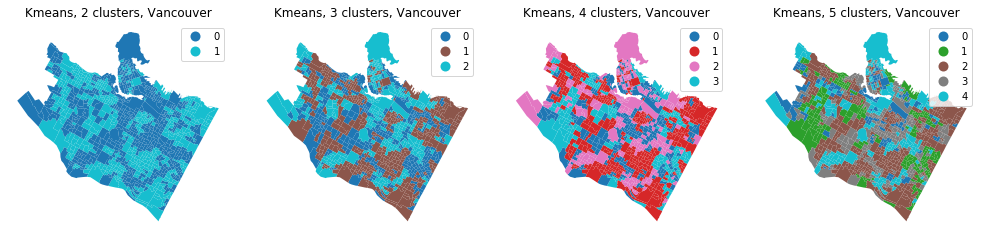

In [61]:
ncols = 4
fig, ax = plt.subplots(ncols=ncols, figsize=(14,10))
k = 2
for j in range(ncols):
    gdf.plot(column=f'{method}_{k}', categorical=True, figsize=(10,8), legend=True, ax=ax[j]);
    ax[j].set_title(f'{method.capitalize()}, {k} clusters, Vancouver')
    ax[j].axis('off');
    k += 1
fig.tight_layout()

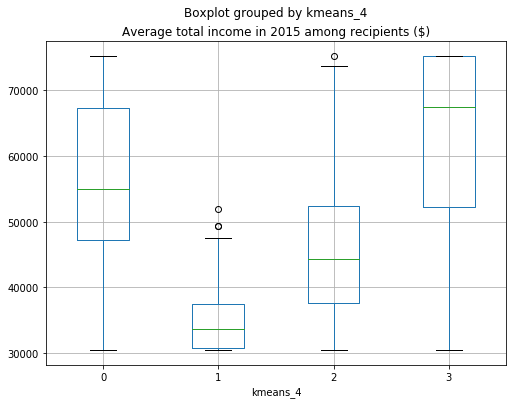

In [67]:
gdf.boxplot(column='Average total income in 2015 among recipients ($)', by='kmeans_4', figsize=(8,6));

## HAC

In [69]:
method = 'hac'
data = pd.read_csv(f'../models/british_columbia/{city}/{method}/data.csv')

# Assign variable names to data
data.columns = variable_names

gdf = pd.merge(geometry, data, left_index=True, right_index=True)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.crs = {'init': 'epsg:3347'}

In [70]:
k_min = 2
k_max = 5
for k in range(k_min, k_max + 1):
    gdf[f'{method}_{k}'] = np.load(f'../models/british_columbia/{city}/{method}/{k}_cluster_labels.npy', allow_pickle=True)
    print(gdf[f'{method}_{k}'].value_counts())
    print()

1    992
0      4
Name: hac_2, dtype: int64

0    992
1      3
2      1
Name: hac_3, dtype: int64

0    987
1      5
3      3
2      1
Name: hac_4, dtype: int64

4    572
0    415
1      5
3      3
2      1
Name: hac_5, dtype: int64



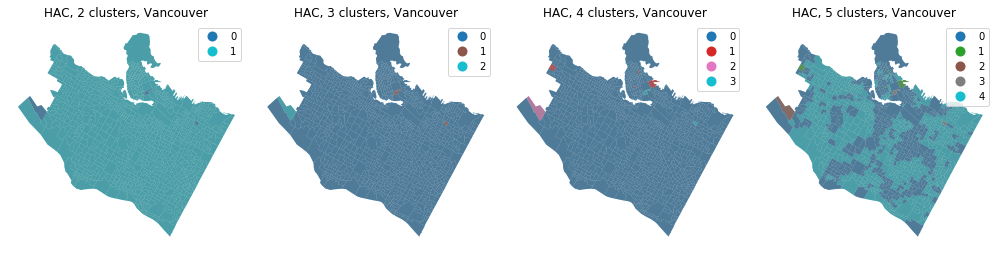

In [71]:
ncols = 4
fig, ax = plt.subplots(ncols=ncols, figsize=(14,10))
k = 2
for j in range(ncols):
    gdf.plot(column=f'{method}_{k}', categorical=True, figsize=(10,8), legend=True, ax=ax[j]);
    geometry.plot(ax=ax[j], alpha=.5, color='gray')
    ax[j].set_title(f'{method.upper()}, {k} clusters, Vancouver')
    ax[j].axis('off');
    k += 1
fig.tight_layout()

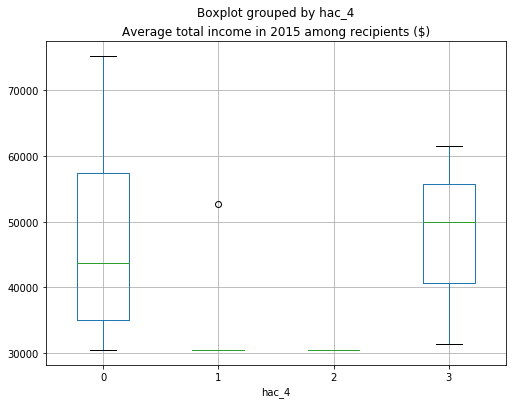

In [72]:
gdf.boxplot(column='Average total income in 2015 among recipients ($)', by='hac_4', figsize=(8,6));

## PAM on the orginial data

In [81]:
method = 'pam'
data = pd.read_csv(f'../models/british_columbia/{city}/{method}/data.csv')

# Assign variable names to data
data.columns = variable_names

gdf = pd.merge(geometry, data, left_index=True, right_index=True)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.crs = {'init': 'epsg:3347'}

In [82]:
k_min = 2
k_max = 5
for k in range(k_min, k_max + 1):
    gdf[f'{method}_{k}'] = pd.read_csv(f'../models/british_columbia/{city}/{method}/{k}_cluster_labels.csv')['pam.res.clustering']
    print(gdf[f'{method}_{k}'].value_counts())
    print()

1    534
2    462
Name: pam_2, dtype: int64

2    372
3    338
1    286
Name: pam_3, dtype: int64

2    355
1    259
3    216
4    166
Name: pam_4, dtype: int64

3    345
1    208
4    165
2    151
5    127
Name: pam_5, dtype: int64



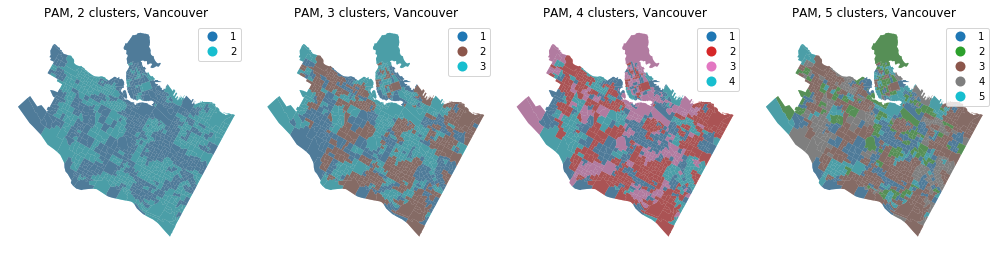

In [83]:
ncols = 4
fig, ax = plt.subplots(ncols=ncols, figsize=(14,10))
k = 2
for j in range(ncols):
    gdf.plot(column=f'{method}_{k}', categorical=True, figsize=(10,8), legend=True, ax=ax[j]);
    geometry.plot(ax=ax[j], alpha=.5, color='gray')
    ax[j].set_title(f'{method.upper()}, {k} clusters, Vancouver')
    ax[j].axis('off');
    k += 1
fig.tight_layout()

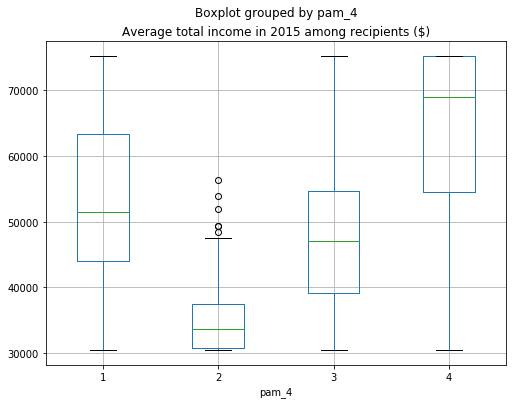

In [84]:
gdf.boxplot(column='Average total income in 2015 among recipients ($)', by=f'{method}_4', figsize=(8,6));

# diceR

In [18]:
# Load the census data and accessibility points

k = ""

if extended_variables == False:
    
    data = pd.read_csv(f'../../data/interim/preprocessed/{city}_short_winsorized.csv') # CHANGE THIS TO short_winsorized.csv once script run!
    
    if city == 'montréal':
        city = 'montreal'
        
    labels = pd.read_csv(f'../../models/{country}/{city}/cc/cluster_labels_short.csv')
else:
    data = pd.read_csv(f'../../data/interim/preprocessed/{city}_winsorized.csv')
    
    if city == 'montréal':
        city = 'montreal'
    
    if country == 'Canada':
        labels = pd.read_csv(f'../../models/{country}/{city}/cc/cluster_labels_no.csv')
    else:
        labels = pd.read_csv(f'../../models/{country}/{city}/cc/cluster_labels{k}.csv')

access = gpd.read_file(f'../../data/processed/accessibility/pois/points_access/{city_initials}_access.shp')
# Assign variable names to data
data.columns = variable_names

gdf = pd.merge(geometry, data, left_index=True, right_index=True)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

if country == 'canada':
    crs = 3347
    
if country == 'united_states':
    crs = 4326
    
gdf.crs = {'init': f'epsg:{crs}'}

if city == 'montréal':
    city = 'montreal'

gdf['kmodes'] = labels['kmodes']

if city == 'houston':
    gdf = gpd.overlay(gdf, limits, how='intersection')

# gdf['majority'] = labels['majority']
print(gdf['kmodes'].value_counts())
# print(gdf['majority'].value_counts())

4    633
3    583
1    414
2    353
5    204
Name: kmodes, dtype: int64


In [19]:
hex_res = 8 # 9 = 415m diameter, 8

if city == 'houston':
    hexgrid = create_hexgrid(limits.to_crs(epsg=4326), hex_res=hex_res, plot=False)
    hexgrid.reset_index(drop=True, inplace=True)
    hexgrid.crs = {'init': 'epsg:4326', 'no_defs': True}
    
else:
    hexgrid = create_hexgrid(geometry.to_crs(epsg=4326), hex_res=hex_res, plot=False)
    hexgrid.reset_index(drop=True, inplace=True)
    hexgrid.crs = {'init': 'epsg:4326', 'no_defs': True}

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
# Distribute population over the hexgrids equally (based on the area)
gdf.to_crs(epsg=4326, inplace=True)
gdf = gdf.reset_index(drop=True)

hexgrid['kmodes'] = 0
# hexgrid['majority'] = 0

hexgrid_polygons = [shape(polygon) for polygon in hexgrid["geometry"].tolist()]
polygons = [shape(polygon) for polygon in gdf["geometry"].tolist()]

for i, hexgrid_polygon in tqdm(enumerate(hexgrid_polygons), total=len(hexgrid_polygons)):
    for j, polygon in enumerate(polygons):
        if hexgrid_polygon.intersects(polygon):
            hexgrid.loc[i, "kmodes"] = gdf.loc[j, "kmodes"]
#             hexgrid.loc[i, "majority"] = gdf.loc[j, "majority"]

if city == 'houston':
    hexgrid = hexgrid[hexgrid['kmodes']!=0]

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
100%|███████████████████████████████████████████████████████████████████████████████| 871/871 [00:08<00:00, 102.56it/s]


In [127]:
# Save the kmodes hexgrid
directory = "../../data/processed/segregation/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
    
if extended_variables == False:
    hexgrid.to_file(directory + f'{city.lower()}_hex{hex_res}_kmodes_short.geojson', index=False, driver = 'GeoJSON')
else:
    hexgrid.to_file(directory + f'{city.lower()}_hex{hex_res}_kmodes{k}.geojson', index=False, driver = 'GeoJSON')

In [11]:
# read data
directory = "../../data/processed/segregation/"
hex_res = 9
if extended_variables == False:
    hexgrid = gpd.read_file(directory + f'{city.lower()}_hex{hex_res}_kmodes_short.geojson', index=False, driver = 'GeoJSON')
else:
    hexgrid = gpd.read_file(directory + f'{city.lower()}_hex{hex_res}_kmodes{k}.geojson', index=False, driver = 'GeoJSON')

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


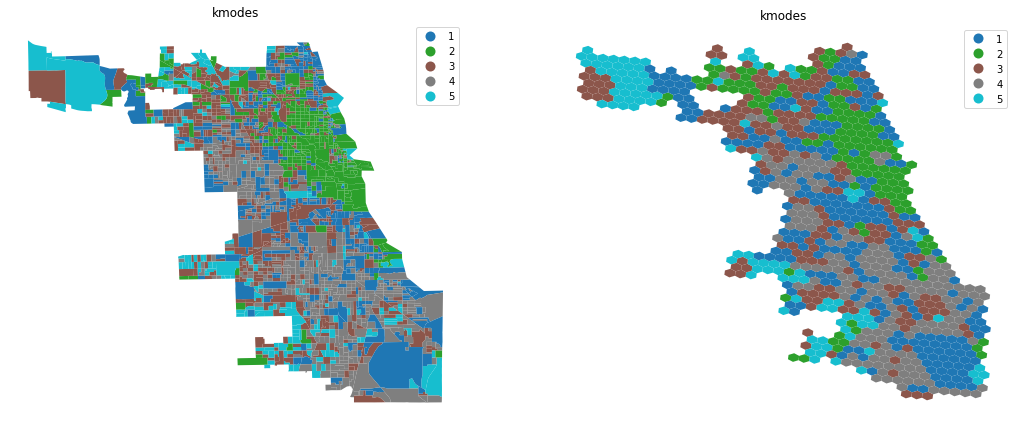

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))
gdf.to_crs(epsg=crs).plot(column='kmodes', categorical=True, legend=True, ax=ax[0])
ax[0].set_title('kmodes')
ax[0].axis('off')
hexgrid.to_crs(epsg=crs).plot(column='kmodes', categorical=True, legend=True, ax=ax[1])
ax[1].set_title('kmodes')
ax[1].axis('off');

IndexError: list index out of range

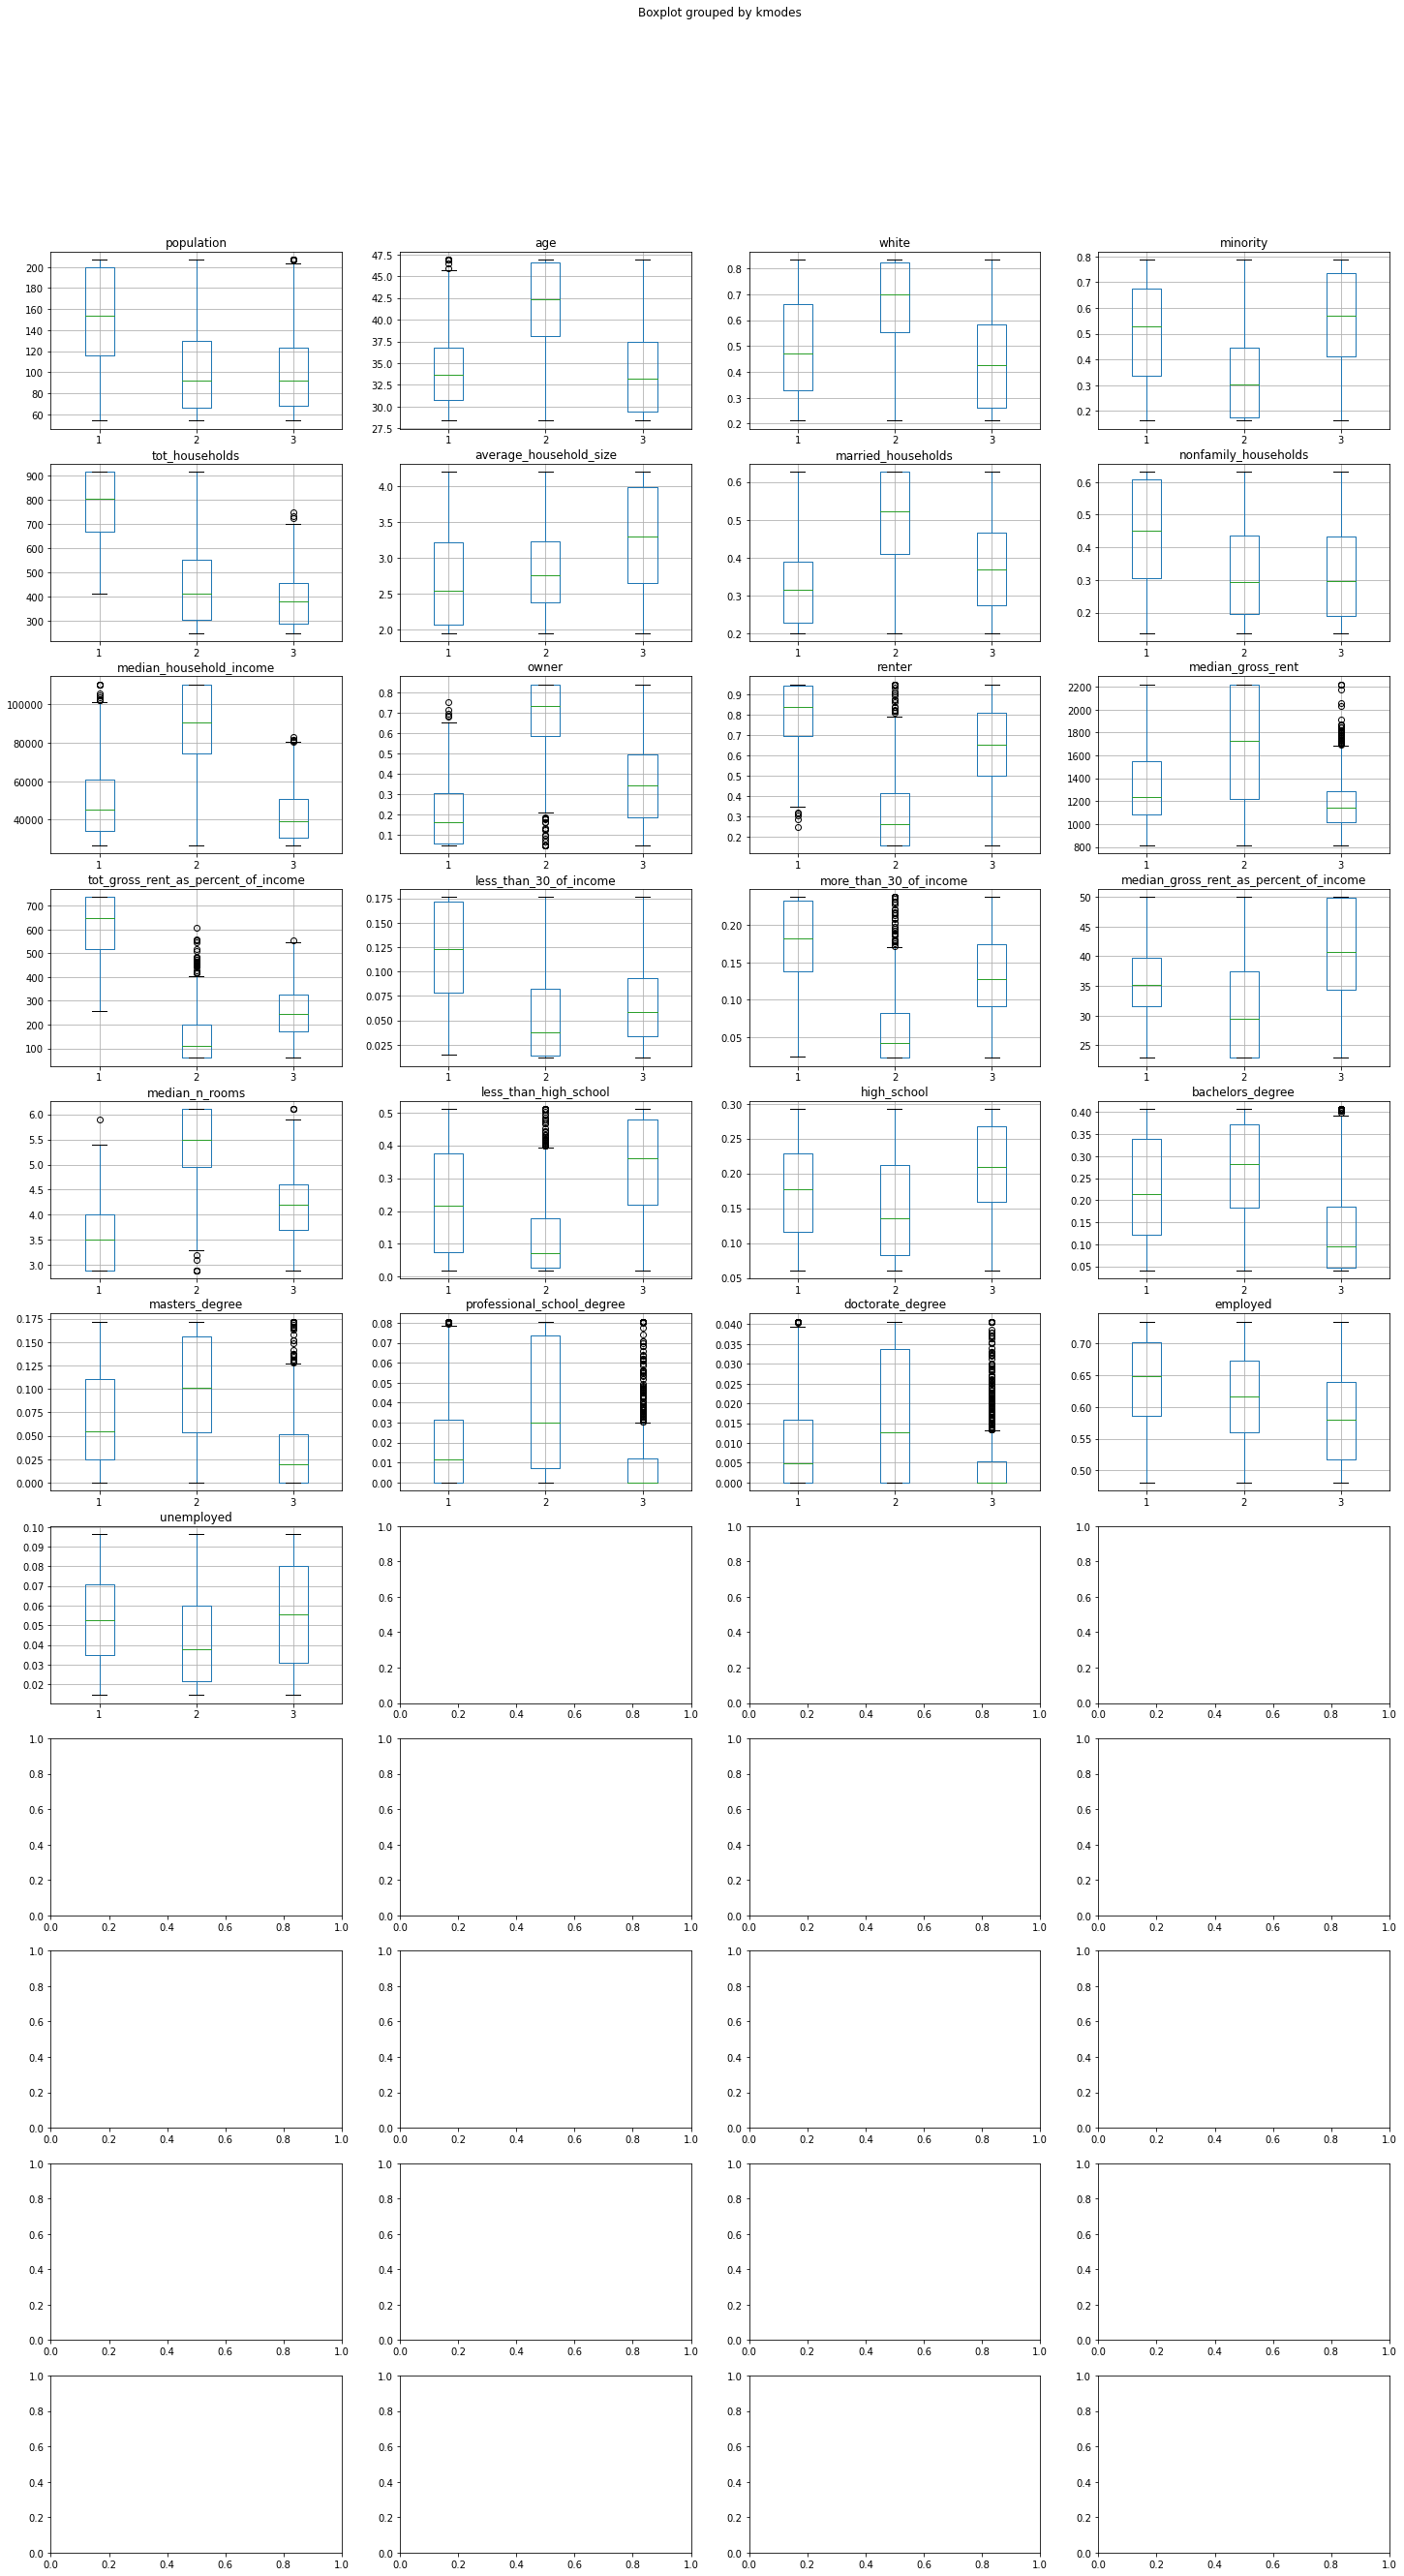

In [13]:
nrows = 11
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(ncols*6),int(nrows*4)))
k = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].set_title(variable_names[k])
        gdf.boxplot(column=[variable_names[k]], by='kmodes', ax=ax[i,j])
        ax[i, j].set_xlabel('')
        k += 1
# fig.tight_layout()

In [ ]:
# fig, ax = plt.subplots(ncols=2, figsize=(16,6))
# gdf.boxplot(column='Total visible minority population', by='kmodes', figsize=(8,6), ax=ax[0])
# gdf.boxplot(column='Average total income in 2015 among recipients ($)', by='kmodes', figsize=(8,6), ax=ax[1])

## Accessibility by Social Cluster

In [22]:
urban_access = create_hex_access(access = access, hexgrid = hexgrid, fillna = None, fillna_value = None)
urban_access = access_score(urban_access, outlier_method = 'winsorize')

C:\Users\Leonardo\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


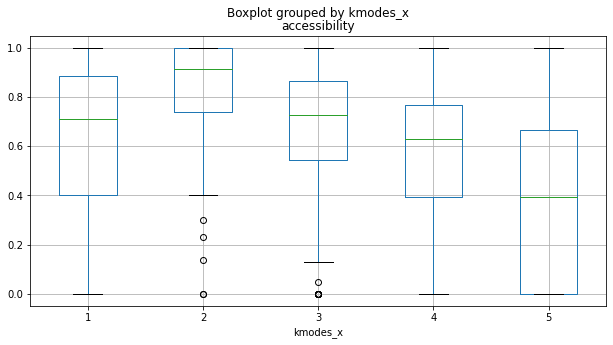

In [23]:
urban_access.boxplot(column='accessibility', by='kmodes_x', figsize = (10,5)) #hex9

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


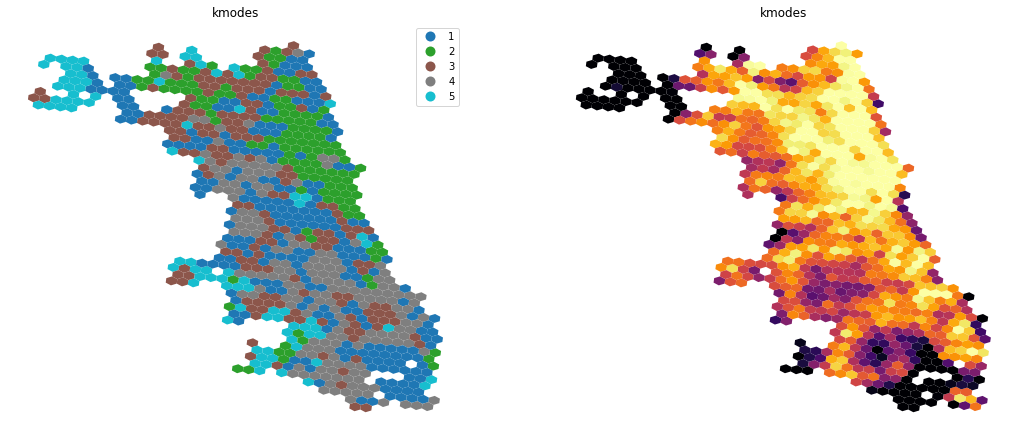

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))
urban_access.to_crs(epsg=crs).plot(column='kmodes_x', categorical=True, legend=True, ax=ax[0])
ax[0].set_title('kmodes')
ax[0].axis('off')
urban_access.to_crs(epsg=crs).plot(column='accessibility', categorical=False, legend=False, ax=ax[1], cmap = 'inferno')
ax[1].set_title('kmodes')
ax[1].axis('off');

## Cluster's "filling"

Needs to be laucnhed after running code cells for PAM.

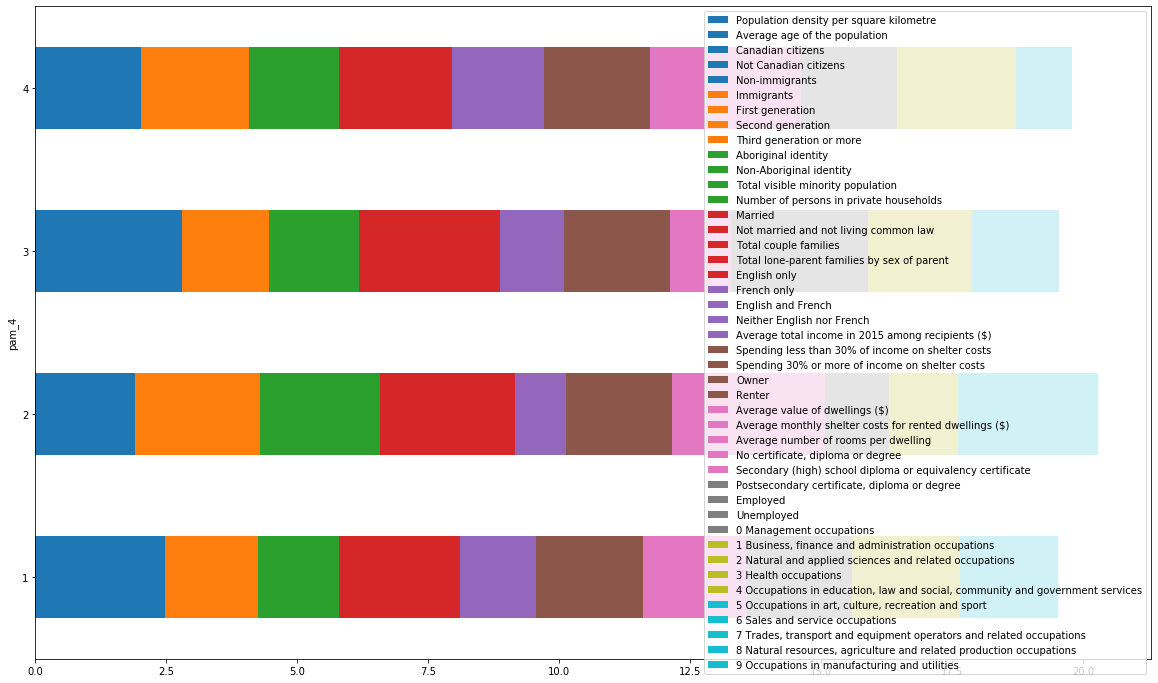

In [90]:
cluster_column = 'kmodes' 
gdf[variable_names] = MinMaxScaler().fit_transform(gdf[variable_names])
df = deepcopy(gdf.drop('geometry', axis=1))[variable_names + [cluster_column]]
df = df.groupby(cluster_column)
df = df.mean()
fig, ax = plt.subplots(figsize=(20, 12))
df.plot(kind='barh', stacked=True, ax=ax, cmap='tab10', linewidth=0)

C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:369:

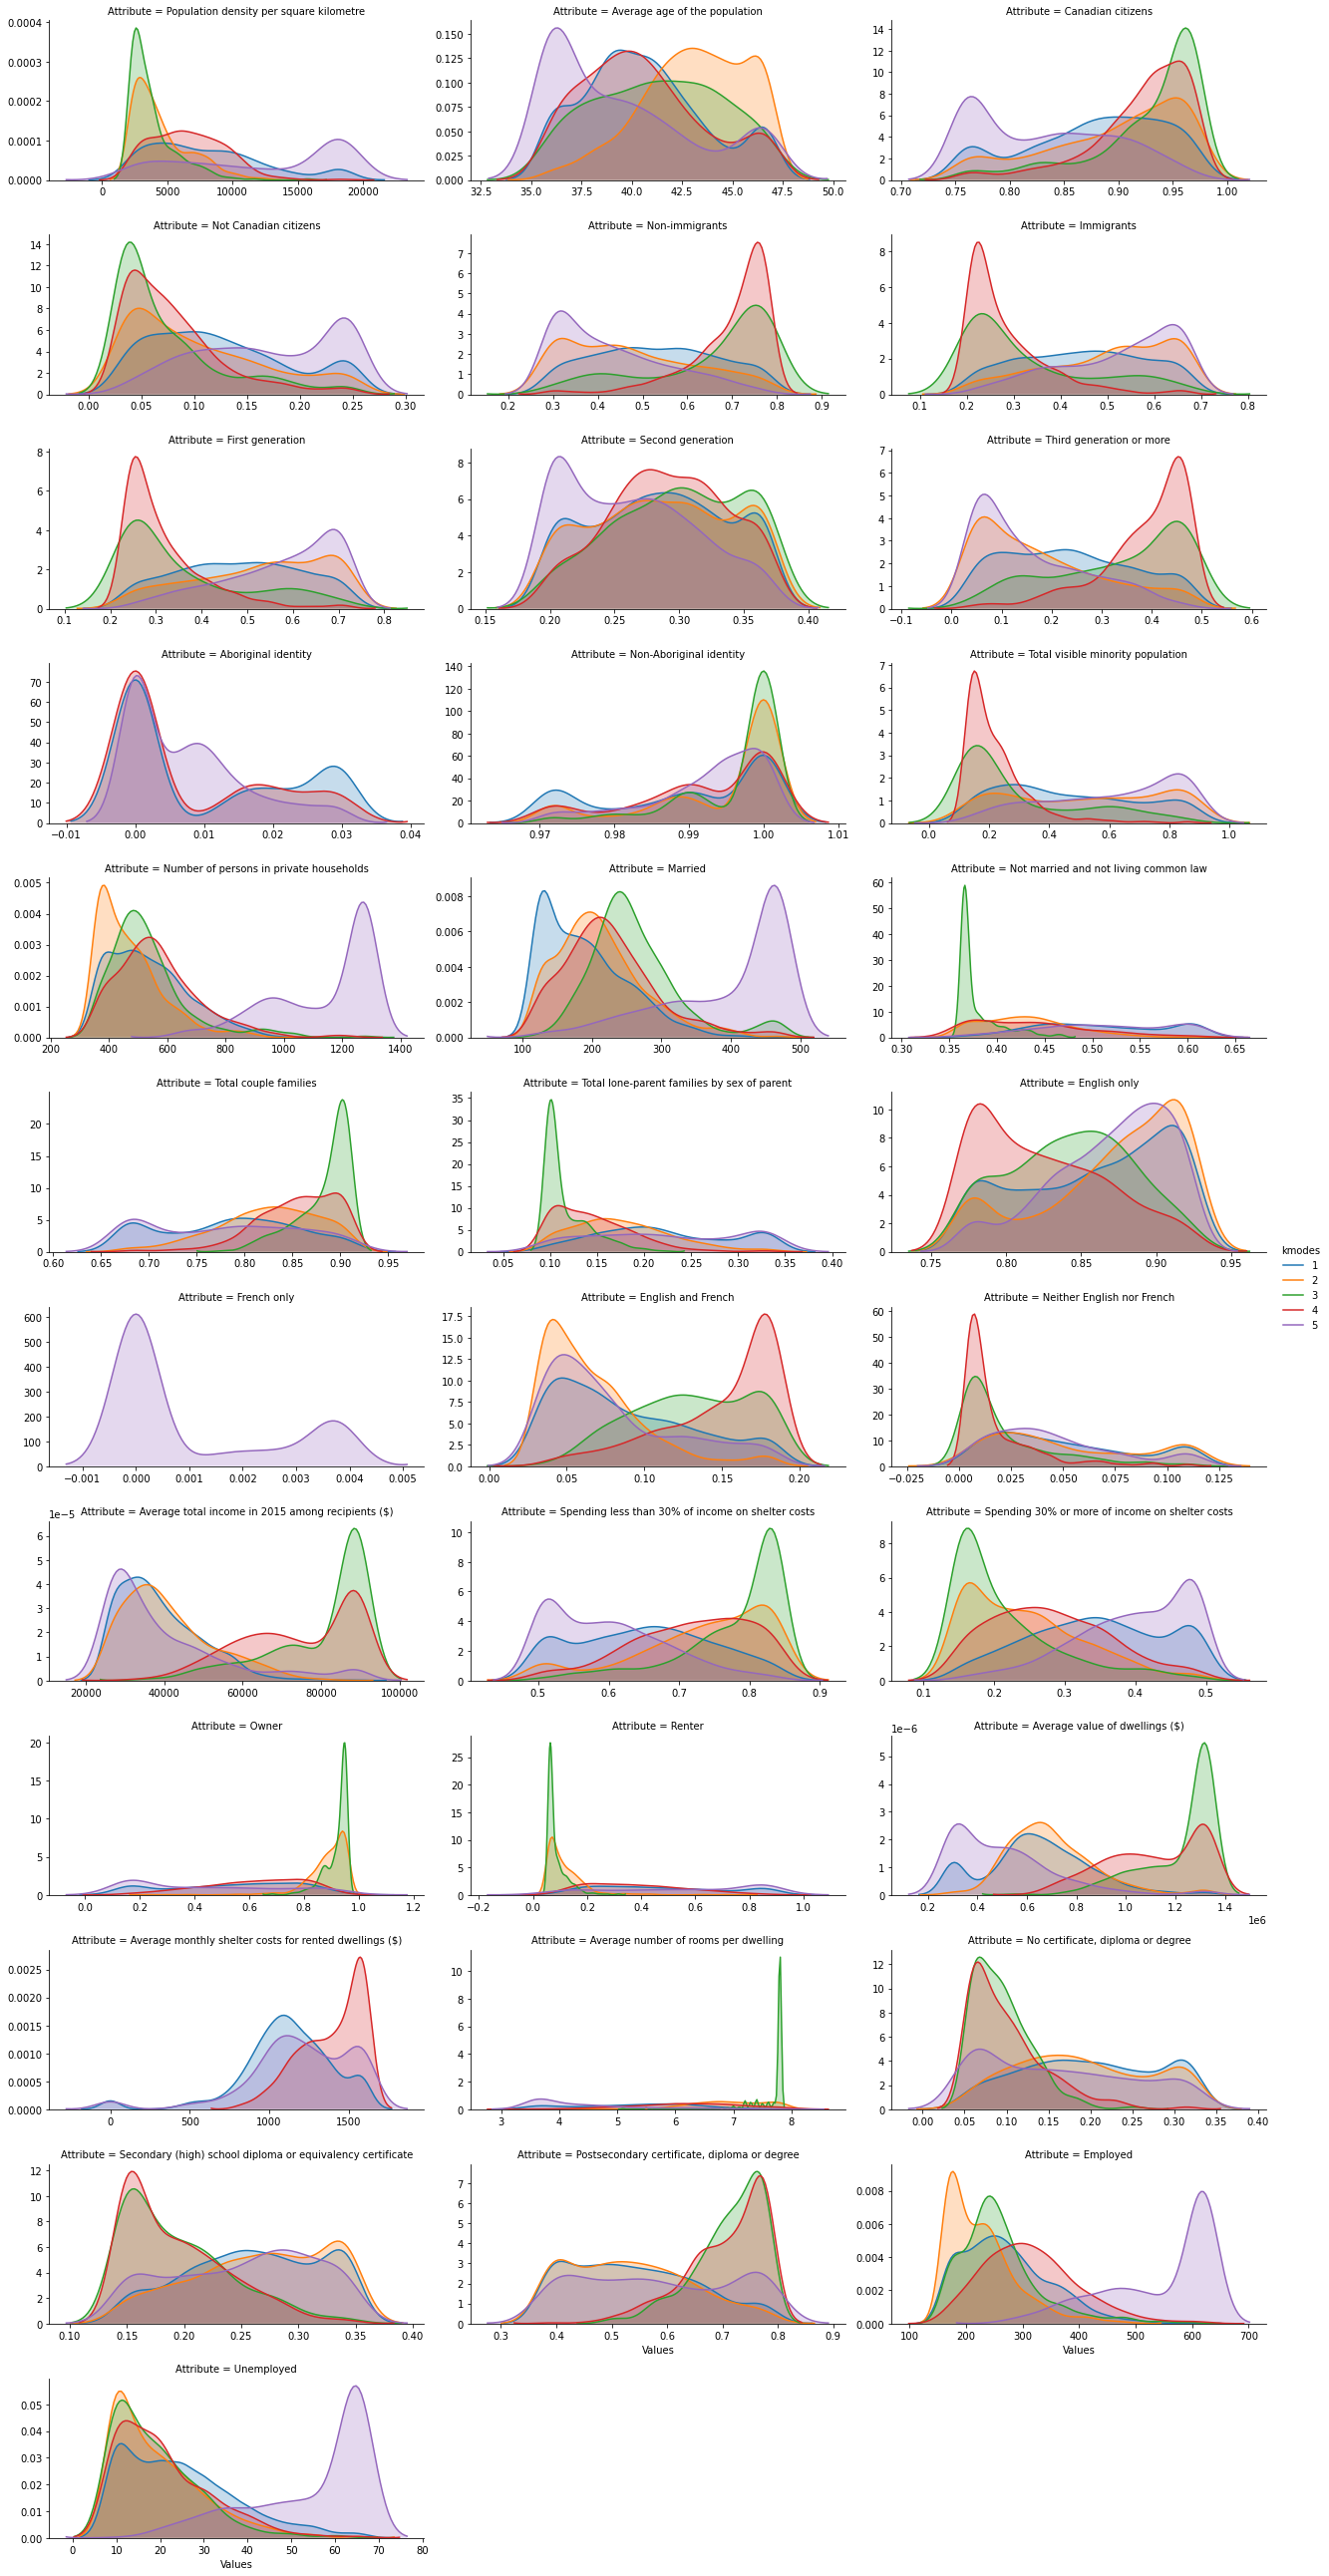

In [58]:
kdeplot(gdf, variable_names, 'kmodes')